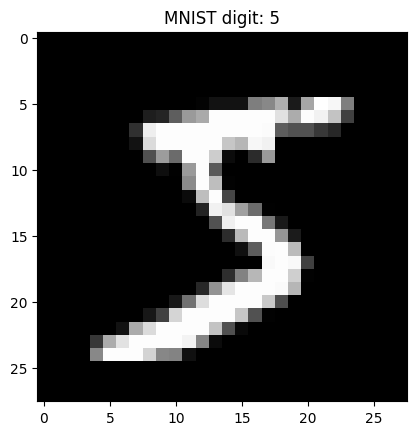

1.98 s for network with 4704 neurons, run for 0.5 s


In [4]:
from brian2 import *
%matplotlib inline
import numpy as np
import pytime
import mnist

x_train, t_train, x_test, t_test = mnist.load()

ind = 0
pat = x_train[ind,:]
plt.imshow(pat.reshape(28,28),cmap='gray')
plt.title(f'MNIST digit: {t_train[ind]}')
plt.show()

def visualize_Hypercolumn(mfrV1, n, FR, k_size):

    titles = [r'Vertical, $\theta=0°$', r'Horizontal, $\theta=90°$', r'ACW from vertical, $\theta=45°$', r'CW from vertical, $\theta=-45°$']
    nL = n**2
    mfr = np.zeros((n,n,4))
    mfr_mean = np.zeros((n,n))
    
    for ii in range(4):
        
        tmp = mfrV1[nL*ii : nL*(ii+1)]/FR
        tmp = tmp.reshape(n,n)
        mfr[:,:,ii] = asarray(tmp)
        mfr_mean += tmp/4
        
        plt.subplot(2,2,ii+1)
        plt.imshow(tmp,cmap='gray',vmin=0,vmax=1)
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[ii])
        plt.suptitle(f'Kernel size {k_size}x{k_size}')
    
    plt.figure()
    plt.imshow(mfr_mean,cmap='gray',vmin=0,vmax=1)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Mean V1')
    
n = 28
nL1 = nL2 = n**2
nv1 = 4
nL3 = nv1*4

[X,Y] = np.meshgrid(range(n), range(n))
[Xv1,Yv1] = np.meshgrid(range(nv1), range(nv1))

taum = 10*ms
taue = taui = 5*ms
duration = 500*ms

eqsPOISSON ='''
rates : Hz
x : 1 (constant)
y : 1 (constant)
'''

eqsLGN ='''
dv/dt  = (ge-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
x : 1 (constant)
y : 1 (constant)
'''

eqsV1 ='''
dv/dt  = (ge-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
x : 1 (constant)
y : 1 (constant)
ori : 1 (constant)
'''

cond_ver = 'ori_post==0 and abs(y_pre-y_post)<=3 and abs(x_pre-x_post)<=1 or '
cond_hor = 'ori_post==1 and abs(x_pre-x_post)<=3 and abs(y_pre-y_post)<=1 or '
cond_CW = 'ori_post==2 and abs(y_pre-y_post)<=3 and abs(x_pre-x_post)<=3 and x_pre-x_post+y_pre-y_post<=1.5 and x_pre-x_post+y_pre-y_post>=-1.5 or '
cond_ACW = 'ori_post==3 and abs(y_pre-y_post)<=3 and abs(x_pre-x_post)<=3 and -x_pre+x_post+y_pre-y_post<=1.5 and -x_pre+x_post+y_pre-y_post>=-1.5'
condV1 = cond_ver + cond_hor + cond_CW + cond_ACW

################################################## Layer 1 ################################################################

L1 = NeuronGroup(nL1,
                 eqsPOISSON,
                 threshold='rand()<rates*dt')

L1.x = X.flatten()
L1.y = Y.flatten()
FR = 100*Hz
L1.rates = pat*FR

################################################## Layer 2 ################################################################

L2 = NeuronGroup(nL2,
                 eqsLGN,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2.x = X.flatten()
L2.y = Y.flatten()

e1 = Synapses(L1, L2, on_pre='ge += 8*volt')
e1.connect(condition = 'i==j')

i1 = Synapses(L1, L2, on_pre='ge -= 1*volt')
i1.connect(condition = 'sqrt((x_pre - x_post)**2 + (y_pre-y_post)**2) < 2 and i!=j')

################################################## Layer 3 ################################################################

L3 = NeuronGroup(nL3,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v=0*volt',
                 refractory=5*ms,
                 method='euler')

L3.ori = np.repeat(np.array([0,1,2,3]), nL1)

X3 = np.tile(X.flatten(), (1,4))
X3.flatten()
L3.x = X3.flatten()

Y3 = np.tile(Y.flatten(), (1,4))
Y3.flatten()
L3.y = Y3.flatten()

e2 = Synapses(L2, L3, on_pre='ge += 1/20*volt')
e2.connect(condition = condV1)

###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

nTot = nL1+nL2+nL3

sp = SpikeMonitor(L3)

start = time.time()
run(duration)
print(f'{time.time()-start:.2f} s for network with {nTot} neurons, run for {duration}')

MFR = sp.count/duration

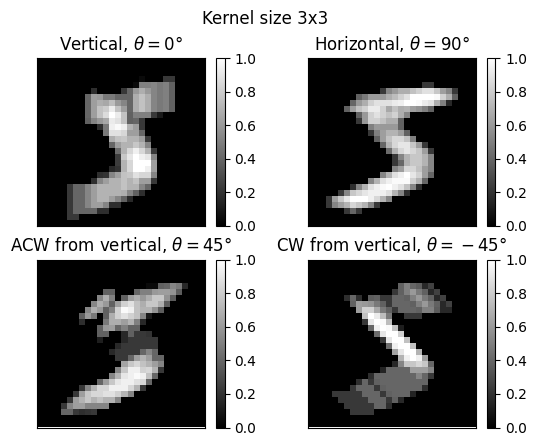

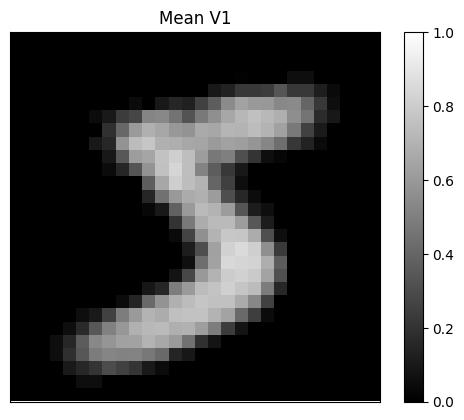

In [5]:
visualize_Hypercolumn(MFR, n, FR, 3)